In [1]:
import functools
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as scint
import scipy.interpolate as scinterp
xr.set_options(keep_attrs=True)
import cmath

from Functions import *

In [2]:
b= 0.023
zR = b/2
omega0 = np.sqrt(lambda_355 * zR / np.pi) # [m] Beam radius at the focus
PXe = 25

pulse_params = {'b' : b,            # [m] confocal parameter
            'zR' : b/2,             # [m] Rayleigh range
            'delta_k': 2/b,        #Phase matching
            'omega0' : omega0,   # [m] beam waist at focus
            'energy' : 0.017,       # [J] single pulse energy
            'duration' : 7e-9}     # [s] single pulse length

harm_params = {'alpha' : 1.5e-50,
            'chi3' : 1.5e-35,
            'PXe' : PXe}

zstart = -0.2
zstop = 0.2
zsamples = 1000
zrange = (zstart, zstop)
z = np.array(np.linspace(zstart, zstop, zsamples,dtype = np.longdouble))

rstop = 10*omega0
rsamples = 1000
r = np.linspace(0,rstop,rsamples,dtype = np.longdouble)


sol_params = {'zstart': zstart,
              'zstop': zstop,
              'zsamples': zsamples,
              'z': z,
              'r': r,
              'rstop': rstop,
              'rsamples': rsamples}


params = {**pulse_params, **harm_params, **sol_params}
initial_vals = (nonzero, nonzero)

In [3]:
z_fine = np.linspace(zstart,zstop,5000)
Phi = np.zeros(len(z_fine))
i =0
for zval in z_fine:
    Phi[i] = evalPhi3(zval, zstart, params['delta_k'], params) #precomputes Phi 3 (interpolated in diff eq)
    i += 1

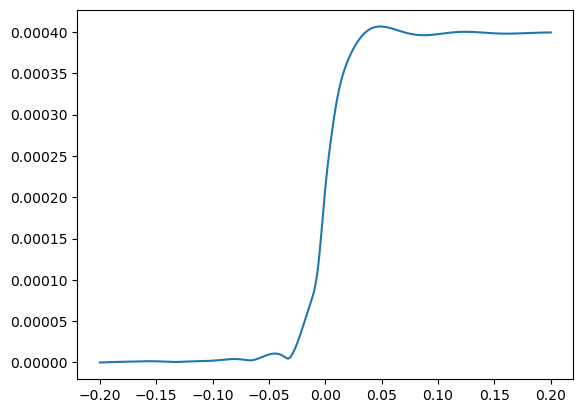

In [40]:
mag2 = np.array(np.zeros(len(z))) # values of the magnitude of J_3 for plotting, similar to phi3
index=0
for num in z:
    mag2[index] = np.sqrt(ReJ3(num,zstart,2/b,params)**2+ImJ3(num,zstart,2/b,params)**2)
    index+=1

boyd118 = (1/2) * k118 * params['chi3']  * peak_amplitude_355(params) **3 \
* mag2 

plt.plot(z,boyd118)

In [41]:
def curly_A_118_NA_Interp(curly_A_118,zval,params):
    z = params['z']
    interp_func = scinterp.interp1d(z,curly_A_118,kind='cubic', fill_value='extrapolate')
    return interp_func(zval)

In [19]:
# alpha = params['alpha']
# Nxe = PXe * Torr_to_m3
# Integrand = lambda z: np.exp((1/2) * alpha * Nxe**2 * z)*curly_A_118_NA_Interp(boyd118,z,params,N)

# Integral = np.zeros(len(z))
# index =0
# for zval in z:
#     Integral[index] = scint.quadrature(Integrand,zstart,zval,maxiter = 5000)[0]
#     index += 1


TypeError: curly_A_118_NA_Interp() missing 1 required positional argument: 'N'

In [20]:
#plt.plot(z,Integrand(z))

In [8]:
#A_118 = boyd118 - ((1/2)*(alpha*Nxe**2))*np.exp(-(1/2)*alpha*Nxe*z)*Integral

In [21]:
#plt.plot(z,A_118*omega0/beam_radius(z,params))

In [42]:
P = np.linspace(0,100,1000)

alpha = params['alpha']

def eval_integrand(z,Nxe):
    return np.exp((1/2) * alpha * Nxe**2 * z)*curly_A_118_NA_Interp(boyd118,z,params)


Integral = np.zeros(len(z))
index =0
for Pval in P:
    Nval = Torr_to_m3*Pval
    integrand = functools.partial(eval_integrand,Nxe=Nval)
    Integral[index] = scint.quadrature(integrand,zstart,zstop,maxiter = 5000)[0]
    index += 1





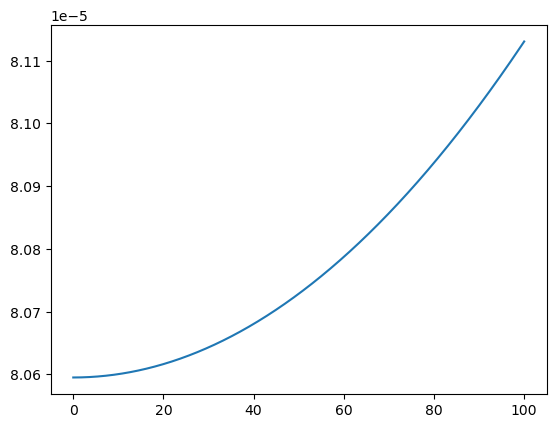

In [45]:
plt.plot(P,Integral)

In [51]:
N = P*Torr_to_m3
A_118 = lambda P: P*Torr_to_m3*boyd118 - ((1/2)*(alpha*(P*Torr_to_m3)**3))*np.exp(-(1/2)*alpha*((P*Torr_to_m3)**2)*zstop)*Integral

(0.0, 1e+18)

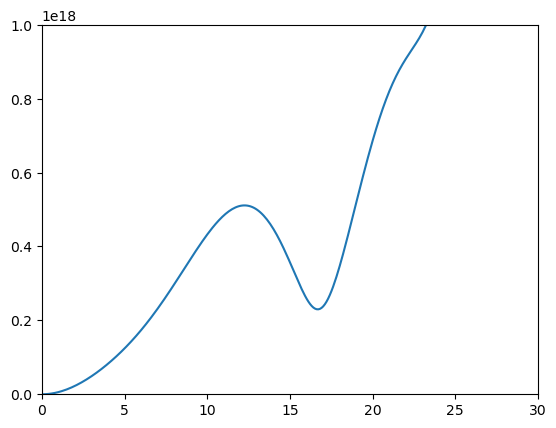

In [56]:
plt.plot(P,A_118(P))
plt.xlim(0,30)
plt.ylim(0,1e18)

In [10]:

sol = solve_diff_eq(curly_GBWA,params,zrange, initial_vals,z,r)

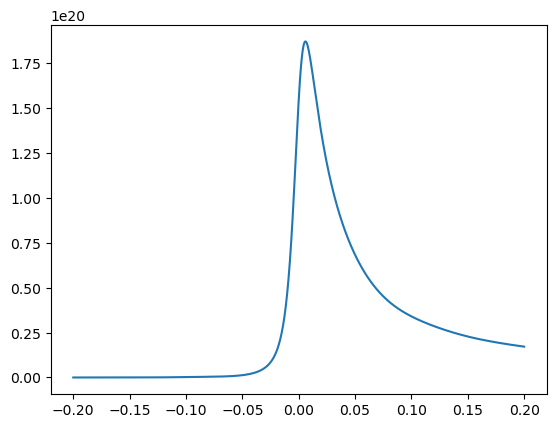

In [11]:
plt.plot(z,sol.beam_118.data[0])

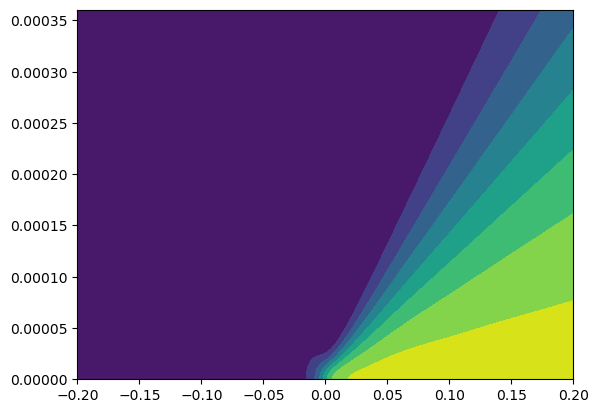

In [12]:
Z,R = np.meshgrid(z,r)
plt.contourf(Z,R,sol.fluor.data)

In [13]:
40*0.84*10**(-37)

3.36e-36

In [14]:
3.237*10**17 /Torr_to_m3

1.079e-05

In [15]:
7.76*10**23/Torr_to_m3

25.866666666666664